In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

Text(0, 0.5, '$y$')

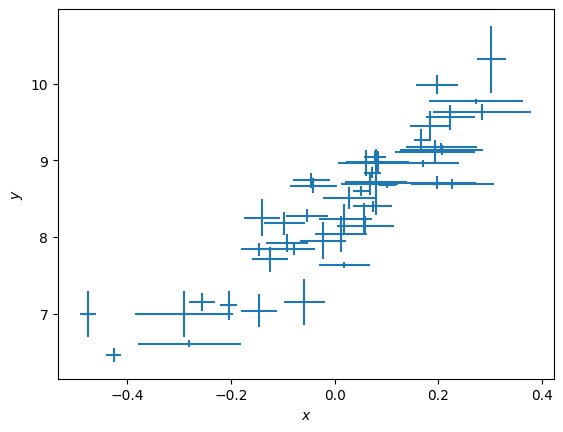

In [34]:
#cargamos los datos
data=pd.read_csv('M_sigma.csv')
x=data['logSigma']
y=data['logM']
x_err=data['err_logSigma']
y_err=data['err_logM']

#Graficamos con barras de error para hacernos una idea de los parametros
plt.errorbar(x, y, yerr=y_err, xerr=x_err, ls='None')
plt.xlabel("$x$")
plt.ylabel("$y$")

In [35]:
#Definimos prior 
def ln_prior(theta):
    m , b , w , Pb , Yb , logVb = theta
    if -10<m<10 and -5<b<20 and 1e-1<w<1e10 and 0<Pb<1 and 0<Yb<20000 and -2<logVb<10: #Vb es varianza por lo que usamos log para restringirlo a los positivos, m=beta , b=alpha
        return 0
    return -np.inf

#Likelihood considerando el scatter instrinsico, incertidumbre en ambas variables y outliers
def ln_likelihood(theta,x,y,xerr,yerr):
    m ,b ,w ,Pb , Yb , logVb = theta
    Vb=10**logVb
    model=m*x+b
    delta=(y-model)**2/(1+m**2)
    sigma=(yerr**2+(m**2*xerr**2))/(1+m**2)
    p_fg=(1-Pb)/np.sqrt(2*np.pi*(sigma+w**2))*np.exp(-delta/(2*(sigma+w**2)))
    p_bg=Pb/np.sqrt(2*np.pi*(sigma+w**2+Vb))*np.exp(-(y-Yb)**2/(2*(w**2+Vb+sigma)))
    return np.sum(np.log(p_fg+p_bg))

def ln_posterior(theta,x,y,xerr,yerr):
    ln_p=ln_prior(theta) 
    if  not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta,x,y,xerr,yerr)
    

In [36]:
#Ejecutamos el sampler
np.random.seed(43)
theta_0=np.array([5.,8.,10.,0.3,500.,2.])                            #Initial guess segun lo observado el grafico 

ndim,nwalkers=6,32

pos0=[theta_0+0.1*np.random.rand(ndim) for i in range(nwalkers)]

sampler=emcee.EnsembleSampler(nwalkers,ndim,ln_posterior,args=(x,y,x_err,y_err),threads=12)
sampler.run_mcmc(pos0,5000)                                                                 #5000 pasos

State([[ 5.90577932e+00  8.27490669e+00  1.02884208e-01  2.85433857e-02
   1.08859255e+04 -1.93171687e+00]
 [ 7.05576569e+00  8.30804387e+00  1.03198064e-01  3.14063621e-03
   1.24714124e+04  1.41041942e+00]
 [ 6.44498780e+00  8.14800973e+00  1.01339328e-01  2.01752423e-02
   4.18917571e+02  9.43465135e+00]
 [ 6.15777638e+00  8.36514304e+00  1.01039753e-01  7.11678054e-03
   1.06236376e+04  7.29767816e+00]
 [ 5.75611420e+00  8.29370030e+00  1.06110154e-01  1.67246112e-03
   6.65673638e+03  9.29124952e+00]
 [ 6.71496109e+00  8.36270968e+00  1.09194974e-01  9.88790786e-03
   1.12920109e+02  7.40236203e-01]
 [ 7.21385010e+00  8.23713776e+00  1.02733563e-01  9.85983464e-03
   6.91487875e+03  1.19419040e+00]
 [ 5.91708934e+00  8.53799087e+00  1.02615868e-01  2.89780576e-03
   9.50673419e+03  7.72861955e+00]
 [ 5.18921570e+00  8.36662317e+00  1.01504502e-01  3.92351935e-02
   2.66731409e+03  4.65095832e+00]
 [ 5.70589285e+00  8.35611934e+00  1.06799848e-01  8.08600569e-03
   1.23165595e+04  

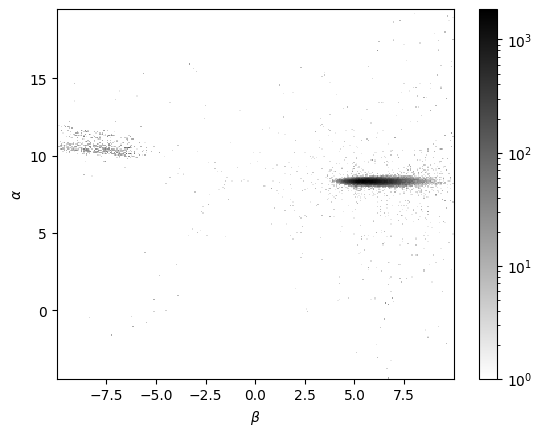

In [37]:
import matplotlib
with plt.style.context('default'):
    # plt.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,1], bins=300, 
    #            cmap='gray_r');
    plt.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,1], bins=300, 
               cmap='gray_r', norm=matplotlib.colors.LogNorm());
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\alpha$')
    plt.colorbar()

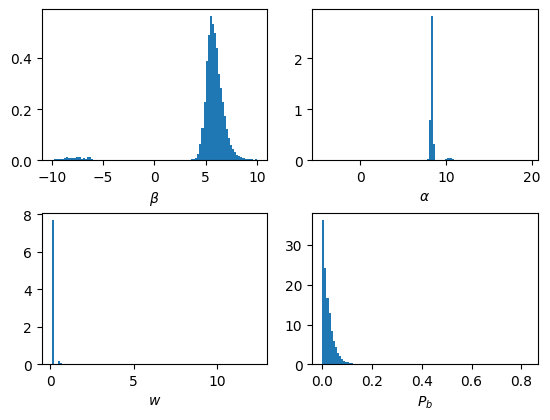

In [38]:
H, xedges, yedges = np.histogram2d(sampler.flatchain[:,0], 
                                   sampler.flatchain[:,1], bins=300)
X, Y = np.meshgrid(xedges, yedges)


with plt.style.context('default'):
    
    plt.subplot(221)
    plt.hist(sampler.flatchain[:,0], bins=100, density=True)
    plt.xlabel(r'$\beta$')
    
    
    plt.subplot(222)
    plt.hist(sampler.flatchain[:,1], bins=100, density=True)
    plt.xlabel(r'$\alpha$')
    
    plt.subplot(223)
    plt.hist(sampler.flatchain[:,2], bins=100, density=True)
    plt.xlabel('$w$')

    plt.subplot(224)
    plt.hist(sampler.flatchain[:,3], bins=100, density=True)
    plt.xlabel('$P_b$')
    
    plt.subplots_adjust(top=0.85, hspace=0.35)

Como vemos en las figuras el modelo determino correctamente la pendiente y el intercepto, a su vez determino que el scatter intrinsico es practicamente inexistente asi como tambien la probabilidad de outliers, esto debido a que los datos tienen muy poca dispersion en y .

Text(0, 0.5, '$y$')

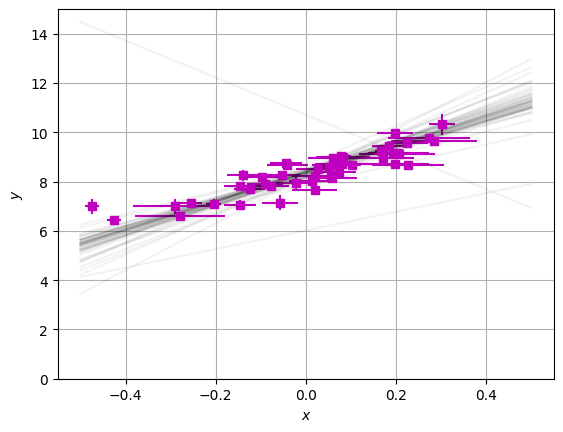

In [39]:
#Graficamos las posibles regresiones
plt.errorbar(x, y, yerr=y_err,xerr=x_err, ls='None', marker='s',c='m')

x_to_plot = np.linspace(-0.5, 0.5, 50)
for i in np.random.randint(0, high=len(sampler.flatchain), size=50):
    m, b = sampler.flatchain[i, [0, 1]]
    plt.plot(x_to_plot, m * x_to_plot + b, color='k', alpha=0.05)

plt.grid(True)
plt.ylim(0,15)
plt.xlabel("$x$")
plt.ylabel("$y$")

Aqui podemos ver claramente que el modelo es coherente a lo esperado

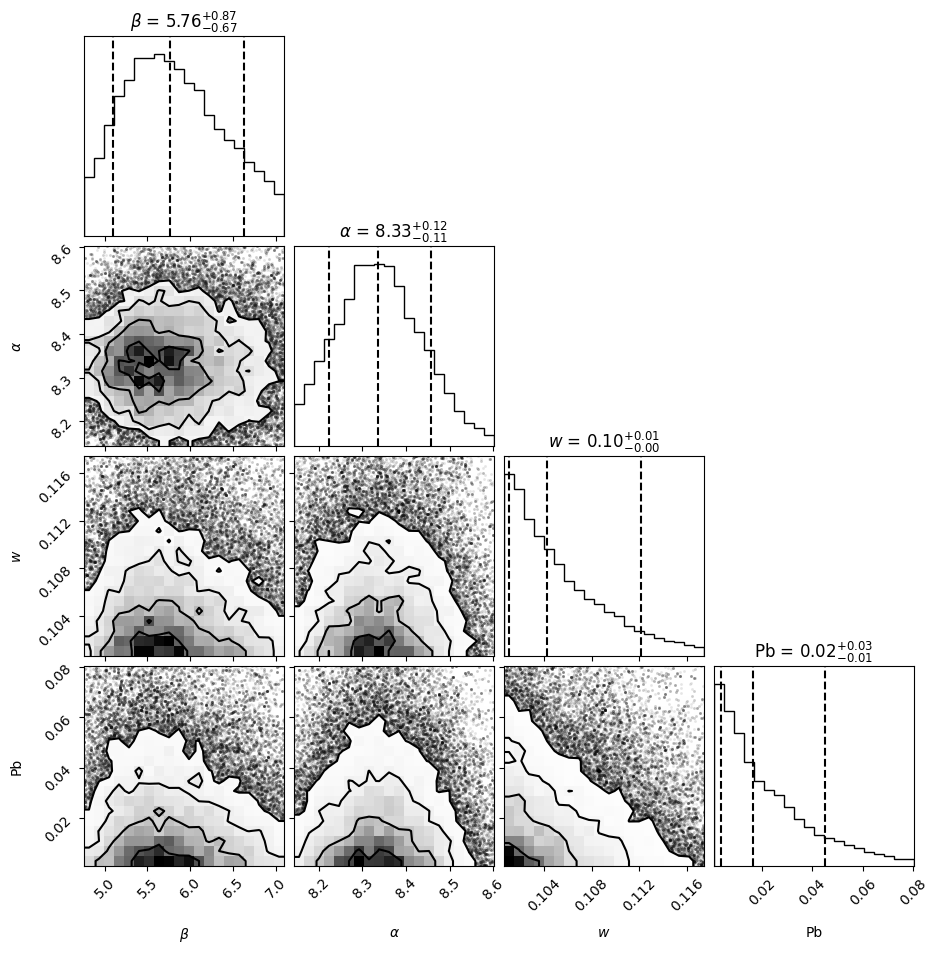

In [46]:
fig = corner.corner(sampler.flatchain[1000:,[0, 1, 2, 3]], 
                    labels=[r"$\beta$", r"$\alpha$", "$w$", "Pb"], 
                    range=(0.85, 0.9, 0.8, 0.9),
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})